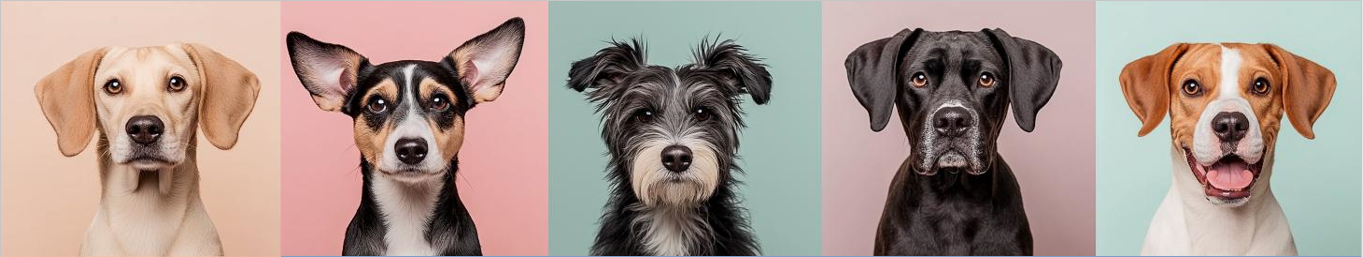

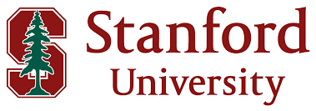

# Notebook 3 - Entraînement de modèles à base de Transfer Learning

# Contexte

Je suis bénévole pour l'association de protection des animaux de mon quartier, Le Refuge. <br/>
L'association aurait besoin d'aide pour mettre à jour sa base de données de pensionnaires.<br/>
L'objectif de ce projet est de leur proposer un algorithme capable de classer les images en fonction de la race du chien présent sur l'image.<br/>

Les étapes que nous allons suivre :<br/>
- **Pré-processer les images** avec des techniques spécifiques *(e.g. whitening, equalization, éventuellement modification de la taille des images)*.<br/>
- Réaliser une **data augmentation** *(mirroring, cropping...)*.<br/>
- Mettre en oeuvre de 2 approches de CNN :<br/>
    - Réaliser notre propre réseau de neurones CNN en optimisant les paramètres.   <br/>  
    - Utiliser le transfert learning.<br/>

**Données disponibles** :<br/>
Un repo Git est disponible pour ce projet à l'adreshttps://github.com/JustineJa/OC_IML_P6n<br/>
Les données sources pour entraîner notre modèle se trouvent ici : http://vision.stanford.edu/aditya86/ImageNetDogs/..com/

<h1><span style="color:#343434" id="sommaire">Sommaire</span></h1>

3. [Chargement des images](#section_3)     
    3.1. [Création du dataset](#section_3_1)     
    3.2. [Chargement des images](#section_3_2)     

4. [Transfer Learing](#section_4)     
    4.1. [VGG16](#section_4_1)     
    4.2. [ResNet50](#section_4_2)

In [1]:
# Import libraries
import os
import warnings
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
import seaborn as sns
import timeit
import time
import cv2 as cv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
#import kerastuner as kt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, silhouette_samples, silhouette_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import preprocessing

# Librairies tensorflow
import keras
import tensorflow_hub as hub
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import  Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import EarlyStopping
import tensorflow.compat.v1 as tf

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import mlflow
from mlflow.models import infer_signature

In [3]:
tf.compat.v1.enable_eager_execution()
print(tf.executing_eagerly()) 


True


In [4]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


# <span style="color:#343434" id="section_3">3. Chargement des images</span>

In [5]:
current_dir = os.getcwd()
current_dir

'C:\\Users\\A475388\\Repo_Github\\OC_IML_P6'

In [6]:
fpath = "./data/Images"
random_seed = 0

In [7]:
img_size = 224
batch_size =32
train = tf.keras.utils.image_dataset_from_directory(
  fpath,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size,
  label_mode ="categorical"
)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [8]:
val = tf.keras.utils.image_dataset_from_directory(
  fpath,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size,
  label_mode ="categorical"
)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [9]:
class_names = train.class_names

In [10]:
names=[]
for name in class_names :
    names.append(name.split("-")[1]) 
    
print(names[:5]) # Printing some species

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']


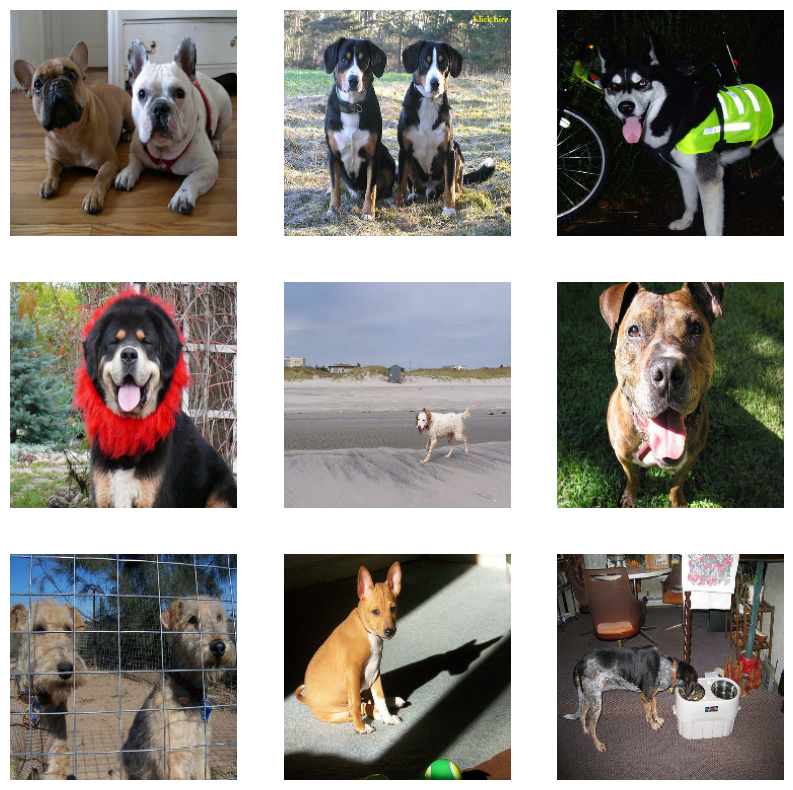

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## <span style="color:#343434" id="section_3_1">3.1. Création du dataset</span>

In [12]:
def preprocessing_cnn(directories, img_width, img_height):
    img_list=[]
    labels=[]
    for index, breed in enumerate(directories):
        for image_name in os.listdir(images_dir+"/"+breed):
            # Read image
            img = cv.imread(images_dir+"/"+breed+"/"+image_name)
            # Resize image
            dim = (img_width, img_height)
            img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
            # Convert modified img to array
            img_array = image.img_to_array(whitened_image)
            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(breed.split("-")[1])
    
    return img_list, labels

In [13]:
def preprocessing_cnn(directories):
    img_path_list=[]
    labels=[]
    # dataset
    for index, breed in enumerate(directories):
        for image_name in os.listdir(images_dir+"/"+breed):
            # Read image
            img = cv.imread(images_dir+"/"+breed+"/"+image_name)
            
            img_path = images_dir+"/"+breed+"/"+image_name
            #print(img_path)
            # Append lists of labels and images
            img_path_list.append(img_path)
            labels.append(breed.split("-")[1])
    
    return img_path_list, labels

In [14]:
images_dir = "./data/Images"
list_races = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 
              'n02092002-Scottish_deerhound', 'n02112018-Pomeranian', 'n02108915-French_bulldog']
X, y = preprocessing_cnn(list_races)

In [15]:
data = pd.DataFrame({
    'file_path': X,
    'label': y
})

In [16]:
data.shape

(1101, 2)

In [17]:
data['file_path']

0       ./data/Images/n02085936-Maltese_dog/n02085936_...
1       ./data/Images/n02085936-Maltese_dog/n02085936_...
2       ./data/Images/n02085936-Maltese_dog/n02085936_...
3       ./data/Images/n02085936-Maltese_dog/n02085936_...
4       ./data/Images/n02085936-Maltese_dog/n02085936_...
                              ...                        
1096    ./data/Images/n02108915-French_bulldog/n021089...
1097    ./data/Images/n02108915-French_bulldog/n021089...
1098    ./data/Images/n02108915-French_bulldog/n021089...
1099    ./data/Images/n02108915-French_bulldog/n021089...
1100    ./data/Images/n02108915-French_bulldog/n021089...
Name: file_path, Length: 1101, dtype: object

## <span style="color:#343434" id="section_3_2">3.2. Chargement des images</span>

### Méthode 1

In [18]:
def load_and_preprocess_image(image_path):
    # Load the image with target size (224, 224)
    image = load_img(image_path, target_size=(224, 224))
    # Convert the image to a numpy array
    image_array = img_to_array(image)
    # Expand dimensions to match the input shape of VGG16 (batch_size, height, width, channels)
    image_array = np.expand_dims(image_array, axis=0)
    # Preprocess the image for VGG16
    image_array = preprocess_input(image_array)
    return image_array

In [19]:
# List of image paths
image_paths = data['file_path'].to_list()
image_paths

['./data/Images/n02085936-Maltese_dog/n02085936_10073.jpg',
 './data/Images/n02085936-Maltese_dog/n02085936_10130.jpg',
 './data/Images/n02085936-Maltese_dog/n02085936_10148.jpg',
 './data/Images/n02085936-Maltese_dog/n02085936_10197.jpg',
 './data/Images/n02085936-Maltese_dog/n02085936_10199.jpg',
 './data/Images/n02085936-Maltese_dog/n02085936_10273.jpg',
 './data/Images/n02085936-Maltese_dog/n02085936_10297.jpg',
 './data/Images/n02085936-Maltese_dog/n02085936_10307.jpg',
 './data/Images/n02085936-Maltese_dog/n02085936_10377.jpg',
 './data/Images/n02085936-Maltese_dog/n02085936_10397.jpg',
 './data/Images/n02085936-Maltese_dog/n02085936_10447.jpg',
 './data/Images/n02085936-Maltese_dog/n02085936_10610.jpg',
 './data/Images/n02085936-Maltese_dog/n02085936_10625.jpg',
 './data/Images/n02085936-Maltese_dog/n02085936_10646.jpg',
 './data/Images/n02085936-Maltese_dog/n02085936_10661.jpg',
 './data/Images/n02085936-Maltese_dog/n02085936_10719.jpg',
 './data/Images/n02085936-Maltese_dog/n0

In [20]:
from keras.preprocessing.image import img_to_array, load_img
# Load and preprocess all images
images = [load_and_preprocess_image(image_path) for image_path in image_paths]

In [21]:
# Convert List of Images to a Numpy Array
images_array = np.vstack(images)

In [22]:
images_array.shape

(1101, 224, 224, 3)

In [23]:
img_matrix = preprocess_input(images_array)

### Méthode 2

In [24]:
data.head()

,file_path,label
0,./data/Images/n02085936-Maltese_dog/n02085936_...,Maltese_dog
1,./data/Images/n02085936-Maltese_dog/n02085936_...,Maltese_dog
2,./data/Images/n02085936-Maltese_dog/n02085936_...,Maltese_dog
3,./data/Images/n02085936-Maltese_dog/n02085936_...,Maltese_dog
4,./data/Images/n02085936-Maltese_dog/n02085936_...,Maltese_dog


In [25]:
img_dict = {}
start_clock = time.time()
for item_id in data["file_path"]:
    item_image_path = item_id
    item_image = load_img(item_image_path, target_size=(224, 224))
    item_image = img_to_array(item_image)
    img_dict[item_id] = item_image    
print("Images chargées en {}s".format(round(time.time() - start_clock)))

Images chargées en 2s


In [26]:
img_matrix = np.array([array2d for array2d in img_dict.values()])
img_matrix.shape

(1101, 224, 224, 3)

In [27]:
img_matrix = preprocess_input(img_matrix)

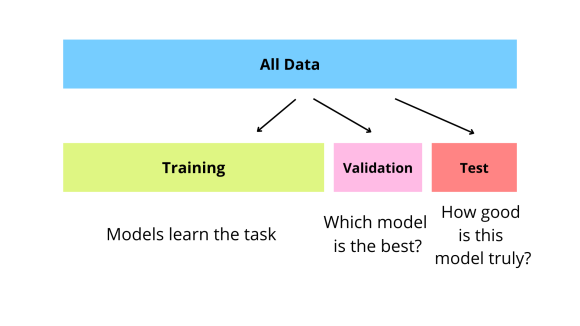

**Nous réalisons notre partition de la manière suivante:**

- Train: 75%
- Validation: 15%
- Test: 10%

In [28]:
lb = preprocessing.LabelBinarizer()
y = data["label"].to_numpy()
lb.fit(y)

# Split into train and temp sets (75% train, 25% temp)
X_train, X_temp, y_train, y_temp = train_test_split(img_matrix, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                   stratify=y)

# Split temp set into validation and test sets (60% validation, 40% test)
X_test, X_val, y_test, y_val = train_test_split(X_temp, 
                                                y_temp, 
                                                test_size=0.6, 
                                                random_state=42,
                                               stratify=y_temp)

y_train = lb.transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)
X_val = preprocess_input(X_val)

In [29]:
print("-" * 50)
print("Taille des sets :")
print("-" * 50)
print("Train set = ",X_train.shape[0])
print("Test set = ",X_test.shape[0])
print("Validation set = ",X_val.shape[0])

--------------------------------------------------
Taille des sets :
--------------------------------------------------
Train set =  825
Test set =  110
Validation set =  166


In [30]:
tot_size = X_train.shape[0] + X_test.shape[0] + X_val.shape[0]
train_size = round(X_train.shape[0] / tot_size,2)
test_size = round(X_test.shape[0] / tot_size,2)
val_size = round(X_val.shape[0] / tot_size,2)

# <span style="color:#343434" id="section_4">4. Transfer Learning</span>

## <span style="color:#343434" id="section_4_1">4.1. VGG16</span>

In [31]:
print(tf.executing_eagerly()) 

True


In [32]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load VGG16 model with pre-trained weights, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent them from being updated during training
base_model.trainable = False

# Create the custom head for our dataset
x = base_model.output
x = Flatten(name="flatten")(x)
#x = Dense(256, activation='relu')(x)  # Added a dense layer for feature learning
#x = tf.keras.layers.Dropout(0.5)(x)  # Dropout layer for regularization
x = Dense(5, activation='softmax')(x)  # Change '5' to the number of classes in your dataset

# Create the final model
model_vgg16 = Model(inputs=base_model.input, outputs=x)

# Model summary
model_vgg16.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │         125,445 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,840,133 (56.61 MB)

 Trainable params: 125,445 (490.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [66]:
from tensorflow.keras.optimizers import SGD
optimizer = "adam"
#optimizer = 'SGD'
batch_size = 50
epoch_nb = 10

In [67]:
model_vgg16.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callback = EarlyStopping(monitor='val_loss', patience=5, min_delta = 0.005, restore_best_weights = True)

In [68]:
start_clock = time.time() 
history = model_vgg16.fit(X_train, 
                y_train, 
                epochs = epoch_nb, 
                batch_size = batch_size, 
                verbose=2, 
                validation_data=(X_val, y_val),  # Use validation_data instead of validation_split
                callbacks = [callback])
print("Modèle entraîné en {}s".format(round(time.time() - start_clock)))

Epoch 1/10
17/17 - 31s - 2s/step - accuracy: 0.9976 - loss: 0.0811 - val_accuracy: 0.9157 - val_loss: 4.0961
Epoch 2/10
17/17 - 34s - 2s/step - accuracy: 0.9867 - loss: 0.3031 - val_accuracy: 0.8855 - val_loss: 5.4938
Epoch 3/10
17/17 - 35s - 2s/step - accuracy: 0.9818 - loss: 0.5148 - val_accuracy: 0.9217 - val_loss: 4.4091
Epoch 4/10
17/17 - 35s - 2s/step - accuracy: 0.9879 - loss: 0.3416 - val_accuracy: 0.8675 - val_loss: 11.4254
Epoch 5/10
17/17 - 35s - 2s/step - accuracy: 0.9927 - loss: 0.3852 - val_accuracy: 0.9337 - val_loss: 4.3512
Epoch 6/10
17/17 - 34s - 2s/step - accuracy: 0.9988 - loss: 0.0716 - val_accuracy: 0.9096 - val_loss: 5.3145
Modèle entraîné en 204s


In [69]:
# Save the model
model_vgg16.save('vgg16_model.h5')
print("Model saved.")

Model saved.


### Loss & Accuracy

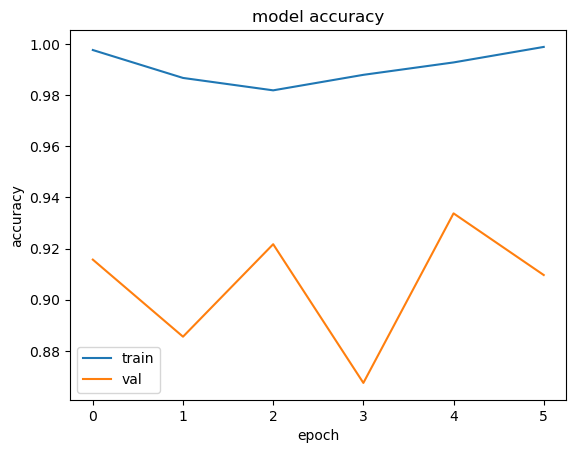

In [70]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

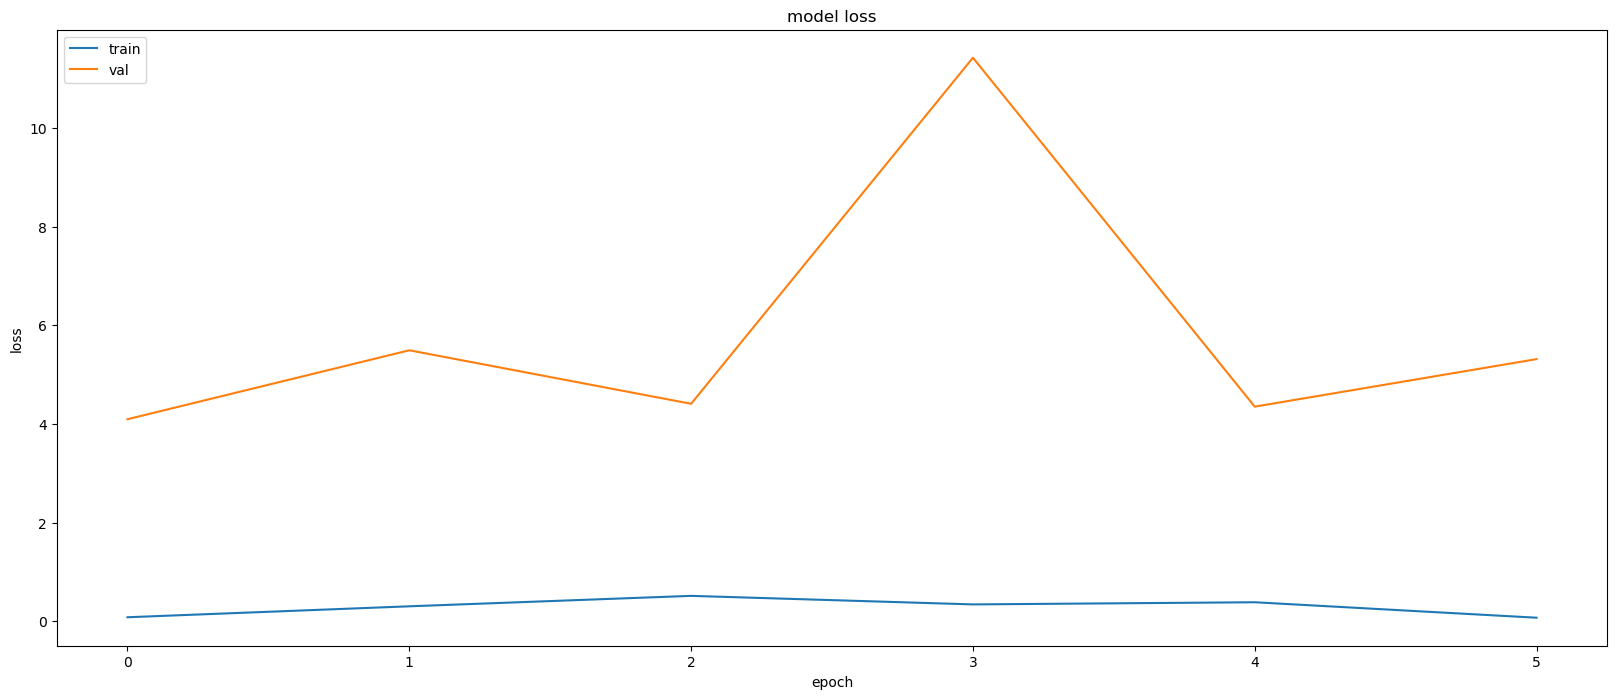

In [71]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Prédiction

In [72]:
loss, accuracy = model_vgg16.evaluate(X_test, y_test, verbose=2)

4/4 - 4s - 946ms/step - accuracy: 0.9091 - loss: 5.3895


In [73]:
print(f"Accuracy is: {round(accuracy*100,2)}%")

Accuracy is: 90.91%


In [74]:
model_prediction = model_vgg16.predict(X_test)
labeled_prediction = lb.inverse_transform(model_prediction)
y_true = lb.inverse_transform(y_test)
accuracy_score(y_true = y_true, y_pred = labeled_prediction)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 941ms/step


0.9090909090909091

In [75]:
supervized_model_score = {}
supervized_model_score["Reconnaissance d'images"] = accuracy_score(y_true = y_true, y_pred = labeled_prediction)

In [76]:
cm = confusion_matrix(y_true = y_true, y_pred = labeled_prediction)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Maltese_dog'),
  Text(1, 0, 'Afghan_hound'),
  Text(2, 0, 'Scottish_deerhound'),
  Text(3, 0, 'Pomeranian'),
  Text(4, 0, 'French_bulldog')])

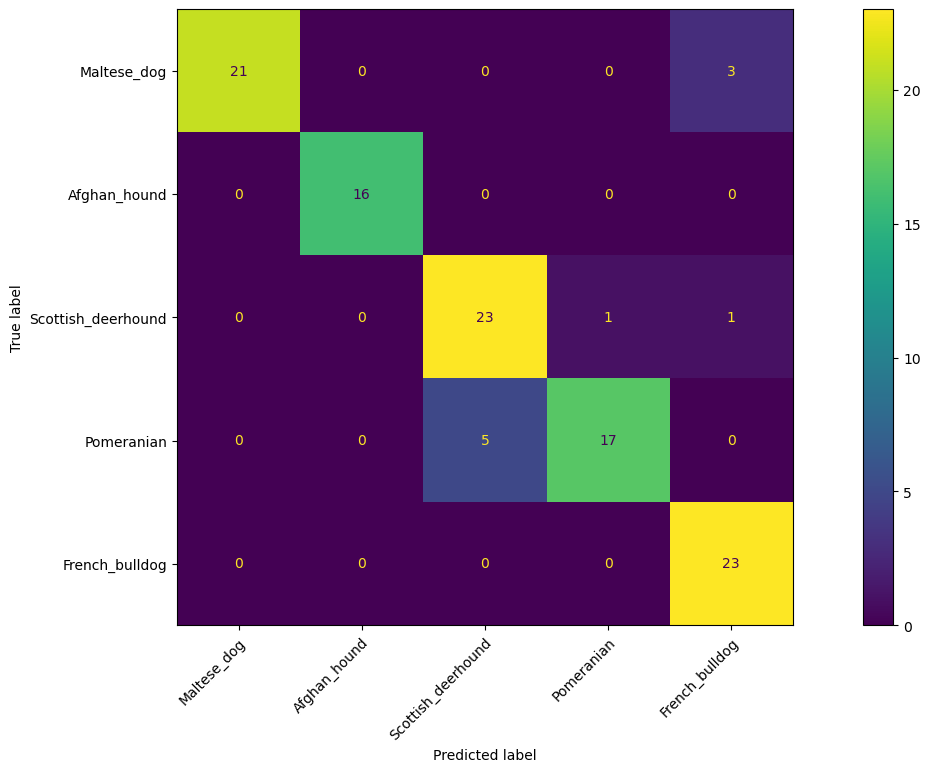

In [77]:
fig, ax = plt.subplots(figsize = (18, 8))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = data["label"].unique())
disp.plot(ax = ax)
plt.xticks(rotation = 45, rotation_mode = "anchor", ha = "right")

### VGG16 MLFlow
mlflow ui --port 5000 dans le terminal

Start the MLflow server using the following command in your terminal or command prompt:
mlflow ui

In [78]:
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")  # Ensure this matches the port where the server is running

# Define experiment name and description
experiment_name = "IML P6"
mlflow.set_experiment(experiment_name)# Start MLflow run
experiment_description = "VGG16 Flatten + dense"

In [79]:
with mlflow.start_run() as run:
    # Log hyperparameters
    mlflow.log_param("Nom test", "VGG16 Flatten + dense")
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epoch_nb)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("val_size", val_size)
    mlflow.log_param("dropout_rate", 0.5)
    mlflow.log_param("callbacks", [callback])

    # Evaluate model
    loss, accuracy = model_vgg16.evaluate(X_test, y_test, verbose=2)
    mlflow.log_metric("loss", loss)
    mlflow.log_metric("accuracy", accuracy)

    # Infer the model signature
    signature = infer_signature(X_train, model_vgg16.predict(X_train))
    
    # Log model
    mlflow.keras.log_model(model_vgg16, "VGG16 Flatten + dense")

print("Model training and logging complete!")

4/4 - 4s - 952ms/step - accuracy: 0.9091 - loss: 5.3895
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step


2024/08/25 18:29:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Model training and logging complete!


## <span style="color:#343434" id="section_4_2">4.2. ResNet</span>

In [80]:
fpath = "./data/Images ResNet"
random_seed = 42

In [81]:
img_size = 224
batch_size =32
optimizer=tf.keras.optimizers.Adam()
#optimizer=SGD(learning_rate=0.01, momentum=0.9)

train = tf.keras.utils.image_dataset_from_directory(
  fpath,
  validation_split=val_size,
  subset="training",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size,
  label_mode ="categorical"
)

Found 1101 files belonging to 5 classes.
Using 936 files for training.


In [82]:
val = tf.keras.utils.image_dataset_from_directory(
  fpath,
  validation_split=val_size,
  subset="validation",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size,
  label_mode ="categorical"
)

Found 1101 files belonging to 5 classes.
Using 165 files for validation.


In [83]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# Load the ResNet50 model with pre-trained weights (excluding the top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(256, activation='relu')(x)
x = Dense(5, activation='softmax')(x)  # Assuming 5 classes

# Create the final model
model_resnet = Model(inputs=base_model.input, outputs=x)

In [84]:
from tensorflow.keras.optimizers import RMSprop
model_resnet.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=optimizer,
      metrics=["accuracy"] 
  )

In [85]:
model_resnet.build((img_size, img_size, 3))

In [86]:
model_resnet.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [87]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 min_delta = 0, 
                                                 patience = 5,
                                                 verbose = 1, 
                                                 restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                  factor=0.2,
                                                  patience=5, 
                                                  min_lr=0.0001)

In [88]:
start_clock = time.time() 
history = model_resnet.fit(X_train, 
                y_train, 
                epochs = epoch_nb, 
                batch_size = batch_size, 
                verbose=2, 
                #validation_split = 0.2, 
                validation_data=(X_val, y_val),  # Use validation_data instead of validation_split
                callbacks = [callback],
                          )
print("Modèle entraîné en {}s".format(round(time.time() - start_clock)))

Epoch 1/10
26/26 - 21s - 792ms/step - accuracy: 0.7212 - loss: 0.7618 - val_accuracy: 0.9036 - val_loss: 0.3141
Epoch 2/10
26/26 - 13s - 513ms/step - accuracy: 0.9430 - loss: 0.1786 - val_accuracy: 0.9277 - val_loss: 0.2061
Epoch 3/10
26/26 - 13s - 516ms/step - accuracy: 0.9709 - loss: 0.1084 - val_accuracy: 0.9096 - val_loss: 0.2214
Epoch 4/10
26/26 - 14s - 521ms/step - accuracy: 0.9842 - loss: 0.0777 - val_accuracy: 0.9217 - val_loss: 0.1954
Epoch 5/10
26/26 - 14s - 531ms/step - accuracy: 0.9927 - loss: 0.0609 - val_accuracy: 0.9277 - val_loss: 0.1918
Epoch 6/10
26/26 - 14s - 536ms/step - accuracy: 0.9976 - loss: 0.0450 - val_accuracy: 0.9157 - val_loss: 0.2051
Epoch 7/10
26/26 - 14s - 541ms/step - accuracy: 0.9988 - loss: 0.0371 - val_accuracy: 0.9157 - val_loss: 0.2023
Epoch 8/10
26/26 - 14s - 525ms/step - accuracy: 1.0000 - loss: 0.0319 - val_accuracy: 0.9157 - val_loss: 0.2044
Epoch 9/10
26/26 - 14s - 529ms/step - accuracy: 0.9988 - loss: 0.0251 - val_accuracy: 0.9277 - val_loss:

In [89]:
# Save the model
model_resnet.save('resnet_model.h5')
print("Model saved.")

Model saved.


### Loss & Accuracy

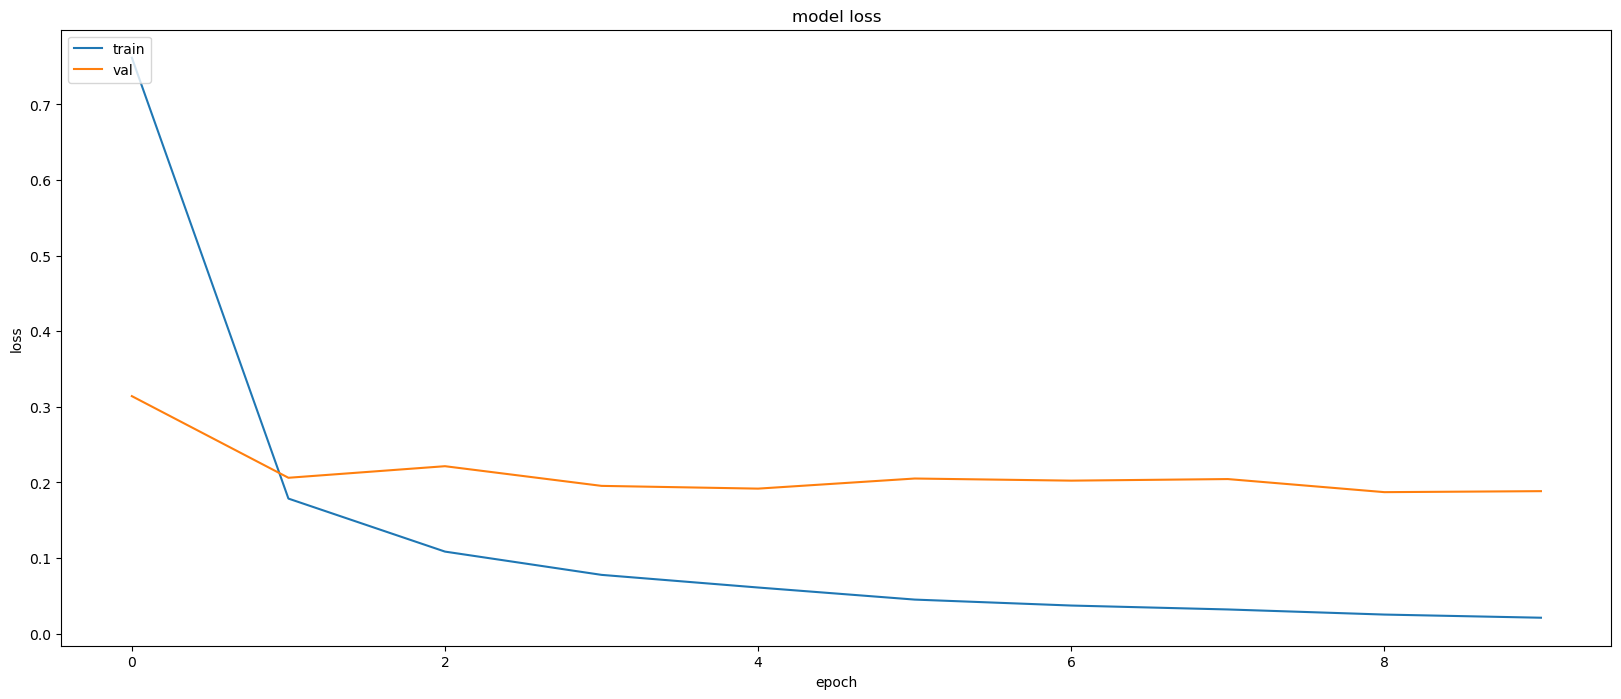

In [90]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

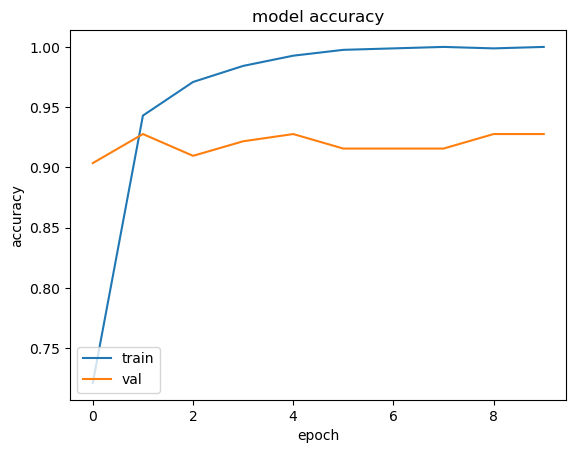

In [91]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

### Prédiction

In [92]:
loss, accuracy = model_resnet.evaluate(X_test, y_test, verbose=2)

4/4 - 2s - 379ms/step - accuracy: 0.9909 - loss: 0.0613


In [93]:
print(f"Accuracy is: {round(accuracy*100,2)}%")

Accuracy is: 99.09%


In [94]:
model_prediction = model_resnet.predict(X_test)
labeled_prediction = lb.inverse_transform(model_prediction)
y_true = lb.inverse_transform(y_test)
accuracy_score(y_true = y_true, y_pred = labeled_prediction)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 940ms/step


0.990909090909091

In [95]:
supervized_model_score = {}
supervized_model_score["Reconnaissance d'images"] = accuracy_score(y_true = y_true, y_pred = labeled_prediction)

In [96]:
cm = confusion_matrix(y_true = y_true, y_pred = labeled_prediction)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Maltese_dog'),
  Text(1, 0, 'Afghan_hound'),
  Text(2, 0, 'Scottish_deerhound'),
  Text(3, 0, 'Pomeranian'),
  Text(4, 0, 'French_bulldog')])

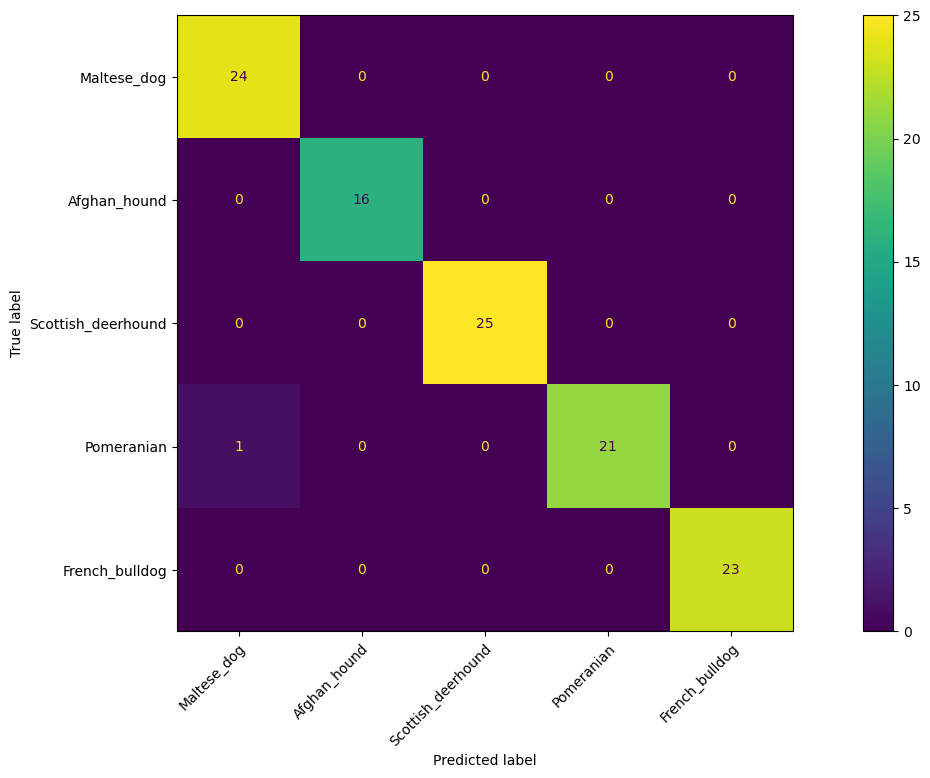

In [97]:
fig, ax = plt.subplots(figsize = (18, 8))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = data["label"].unique())
disp.plot(ax = ax)
plt.xticks(rotation = 45, rotation_mode = "anchor", ha = "right")

### Resnet MLFlow

In [98]:
mlflow.set_experiment(experiment_name)# Start MLflow run
experiment_description = "Resnet Global + dense"

with mlflow.start_run() as run:
    # Log hyperparameters
    mlflow.log_param("Nom test", "Resnet Pooling + dense)")
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epoch_nb)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("val_size", val_size)
    mlflow.log_param("dropout_rate", 0.5)
    mlflow.log_param("callbacks", [callback])
    
    # Evaluate model
    loss, accuracy = model_resnet.evaluate(X_test, y_test, verbose=2)
    mlflow.log_metric("loss", loss)
    mlflow.log_metric("accuracy", accuracy)

    # Infer the model signature
    signature = infer_signature(X_train, model_resnet.predict(X_train))
    
    # Log model
    mlflow.keras.log_model(model_resnet, "Resnet Global + dense")

print("Model training and logging complete!")

4/4 - 1s - 353ms/step - accuracy: 0.9909 - loss: 0.0613
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 408ms/step


2024/08/25 18:32:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Model training and logging complete!
